#### 평가 기준은 두 데이터셋의 test_accuracy이며, 평가 기준은 다음과 같습니다.

0. 제출 파일은 .ipynb 파일, 즉 jupyter notebook 파일입니다.
1. 제출 코드 안에 print(test_accuracy)을 하는 코드를 작성하여, test_accuracy를 출력해주세요.
  (train accuracy를 제출하실 경우 0점 처리입니다.)

2. MNIST : 100점 / CIFAR10 : 100점 기준으로 200점 만점입니다.
  (MNIST의 경우, test_accuracy가 99%을 넘어가면 만점, CIFAR10의 경우, 90%을 넘어가면 만점입니다.)

3. 모델의 layer 개수, hidden node의 개수에는 제한이 없습니다.
4. activation function 또한 제한이 없으나, softmax함수의 경우에는 맨 끝단에만 사용해주세요.
5. dropout, batch normalization의 경우 선택 사항입니다. 모델의 test_accuracy를 높이지 못한다면 굳이 사용하실 필요는 없습니다.

# MNIST

### 1) Library 불러오기

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset # for loading dataset (mnist)
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


### 2) Hyper Parameter 세팅하기

In [10]:
# hypter parameter setting
learning_rate = 1e-4
epochs = 30
display_step = 10
batch_size = 32

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kerel size, stride size, padding size 

### 3)  Data 불러와서 전처리하기

len(train_data):  60000
len(test_data):  10000
data tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
     

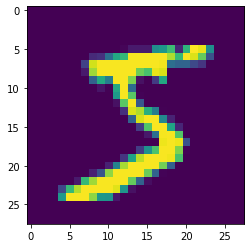

data shape: torch.Size([32, 1, 28, 28])
label: tensor([5, 7, 3, 1, 4, 8, 6, 6, 4, 9, 8, 3, 8, 6, 1, 2, 2, 6, 8, 2, 9, 6, 5, 5,
        0, 8, 7, 6, 2, 1, 7, 4])


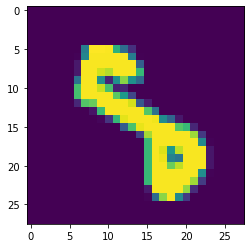

In [11]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

### 4) Model 만들기, 최적화 함수와 오차 함수 적용하기

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 5),   # number of input channel, number of output channel, kernel size   
            activation,  # we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
        
            # SHAPE 계산: 16 * 24 * 24 (number of output channel * output_size^2 = (N-F)/S + 1 = 28-5+1)
            
            nn.Conv2d(16, 32, 5),  # number of input channel, number of output channel, kernel Size
            activation,
            
            # 32 * 20 * 20
            
            max_pool,
            
            # 32 * 10 * 10
            
            nn.Conv2d(32, 64, 5),  # number of input channel, number of output channel, kernel Size
            activation,
            
            # 64 * 6 * 6
            
            max_pool
            
            # (32 *) 64 * 3 * 3
            
        ) # 순서: Convolution Layer - Activation Map - Pooling Layer(max pooling/mean pooling)
        
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3 * 3, 100),
            activation,
            nn.Linear(100, 10)
        )
    def forward(self, x):
        print(x.shape)
        extracted_feature = self.feature_extraction(x) # [32, 64, 3, 3]
        flatten = extracted_feature.view(batch_size, -1) # [32, 576 (64 * 3 * 3)]
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # model.parameters() = 학습할 대상이 되는 모델.

### 5) Train & Test

In [15]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
0 epoch loss: 0.04895589500665665
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

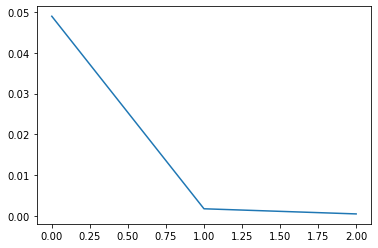

In [16]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [17]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Accuracy of the model: 0.9922876954078674
